In [1]:
import os
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import hmean
from scipy.stats import skewnorm
import datetime
import pickle
from scipy.stats import gmean



path,dirs,files = next(os.walk("./bonito_benchmarks_v2/"))
benchmarks=[]
batch_benchmarks=[]
for f in files:
    if re.search(".*benchmark(?!(batch)).*err",f):
        benchmarks.append(f)
    if re.search(".*benchmark.*batch.*err",f):
        batch_benchmarks.append(f)
                 


strand_run_times={b:{} for b in benchmarks}
score_lengths={b:{} for b in benchmarks}
total_run_times={b:0 for b in benchmarks}


score_length_str = "Score length after alignment:"
batch_length_str = "Score tensor after align:"
read_str = "Decoding Read"
batch_time_str = "Batch Completed in:"
time_str = "Read Completed in:"
failed_read = "- INFO - N"
passed_read = "- INFO - TGCT"
first_readIDs=[]
for b in benchmarks:
    data = open(os.path.join(path,b),"r")
    current_time = None
    current_score = None
    times=[]
    for line in data:
        date_time = re.search("([0-9]+-[0-9]+-[0-9]+) [0-9]+:[0-9]+:[0-9]+,[0-9]+",line)
        if date_time is not None: times.append(datetime.datetime.fromisoformat(date_time.group(0).replace(",",".")+"000"))
        if read_str in line:
            current_readID= re.search("([0-9]|[a-z])+\-([0-9]|[a-z])+\-([0-9]|[a-z])+\-([0-9]|[a-z])+\-([0-9]|[a-z])+",line).group(0)
        if score_length_str in line:
            current_score=int(line.split(score_length_str)[1])
        elif batch_length_str in line:
            current_score=int(line.split(batch_length_str)[1].split(",")[1])
        if time_str in line:
            tmp = line.split(time_str)[1]
            tmp = tmp.split("seconds")[0]
            current_time=float(tmp)
        elif batch_time_str in line:
            tmp = line.split(batch_time_str)[1]
            tmp = tmp.split("seconds")[0]
            current_time=float(tmp)
        if passed_read in line:
            if len(strand_run_times[b])==0:
                first_readIDs.append(current_readID)
            strand_run_times[b][current_readID]=(current_time)
            score_lengths[b][current_readID]=(current_score)
            current_score=None
            current_time=None
            current_readID=None
        elif failed_read in line:
            current_score=None
            current_time=None
            current_readID=None

    total_run_times[b]=(times[-1]-times[0]).total_seconds()
    data.close()
    
    
    
batch_total_run_times={b:0 for b in batch_benchmarks}
for b in batch_benchmarks:
    data=open(os.path.join(path,b),"r")
    for line in data:
        if "Benchmark Completed" in line:
            batch_total_run_times[b]=float(re.search("[0-9]+\.[0-9]+",line).group(0))
print(batch_total_run_times)
print(total_run_times)
    

{'bonito_hedges_benchmark_batch--16.err': 312.61891508102417, 'rna_bonito_hedges_benchmark_batch--4.err': 849.7566604614258, 'rna_bonito_hedges_benchmark_batch--2.err': 1504.0829634666443, 'bonito_hedges_benchmark_batch--32.err': 285.4037981033325, 'bonito_hedges_benchmark_batch--4.err': 551.0435569286346, 'rna_bonito_hedges_benchmark_batch--8.err': 577.0546772480011, 'rna_bonito_hedges_benchmark_batch--16.err': 486.54449486732483, 'bonito_hedges_benchmark_batch--100.err': 288.65446615219116, 'bonito_hedges_benchmark_batch--64.err': 286.13402032852173, 'rna_bonito_hedges_benchmark_batch--32.err': 450.77636551856995, 'rna_bonito_hedges_benchmark_batch--64.err': 425.71159315109253, 'bonito_hedges_benchmark_batch--2.err': 938.0576066970825, 'bonito_hedges_benchmark_batch--8.err': 389.23905777931213}
{'bonito_hedges_benchmark_window--0.err': 1631.0, 'bonito_hedges_benchmark_batch--16.err': 312.546, 'rna_bonito_hedges_benchmark_batch--4.err': 849.701, 'bonito_hedges_benchmark_window--0.3.er

# DNA

Beam Average Time 183.16972318095 183.03833023306706


(5000.0, 15000.0)

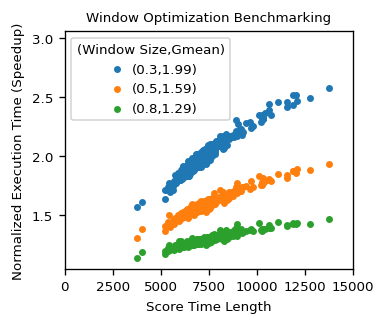

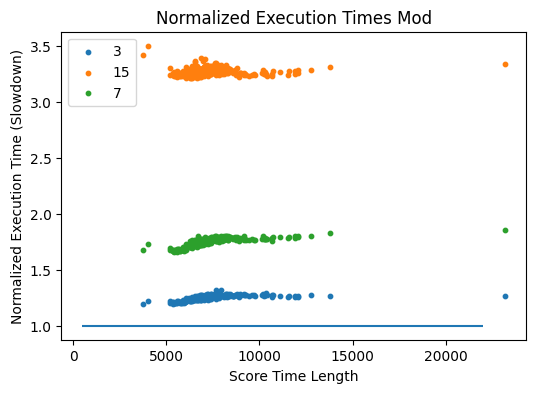

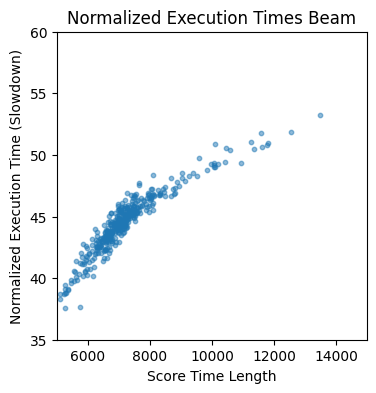

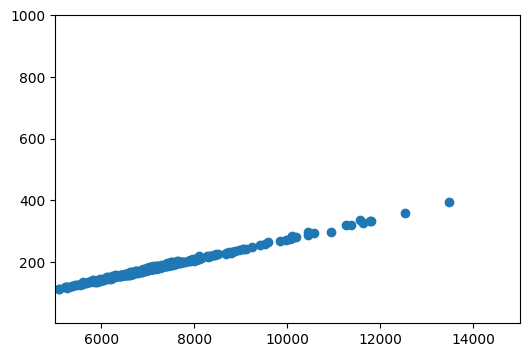

In [2]:
baseline_file = "bonito_hedges_benchmark_window--0.err"
baseline_readIDs = [_ for _ in strand_run_times[baseline_file].keys() if _ not in first_readIDs]
baseline_y =np.array([strand_run_times[baseline_file][_] for _ in baseline_readIDs])
baseline_x =np.array([score_lengths[baseline_file][_] for _ in baseline_readIDs])
plt.figure(figsize=(3.1, 2.6),dpi=120,constrained_layout=True)
#plot normalized run times, window analysis
for b in benchmarks:
    if b==baseline_file: continue
    if "window" in b:
        y = np.array([strand_run_times[b][_] for _ in baseline_readIDs])
        x = np.array([score_lengths[b][_] for _ in baseline_readIDs])
        plt.scatter(x,baseline_y/y,label="({},{:.2f})".format(b.split("--")[1].split(".err")[0].strip(),gmean(baseline_y/y)),s=10.0)
plt.xlim([0,15000])
plt.xlabel("Score Time Length",fontsize=8)
plt.ylabel("Normalized Execution Time (Speedup)",fontsize=8)
plt.title("Window Optimization Benchmarking",fontsize=8)
plt.gca().xaxis.set_tick_params(labelsize=8)
plt.gca().yaxis.set_tick_params(labelsize=8)
l=plt.legend(title="(Window Size,Gmean)",fontsize=8,handletextpad=0.1)
l.get_title().set_fontsize('8')
plt.savefig("ctc_short_window_results.png",dpi=1200)



#plot normalized run times, alignment factor (mod analysis)
plt.figure(figsize=(6, 4))
for b in benchmarks:
    if b==baseline_file: continue
    if "mod" in b:
        y = np.array([strand_run_times[b][_] for _ in baseline_readIDs])
        x = np.array([score_lengths[b][_] for _ in baseline_readIDs])
        plt.scatter(x,y/baseline_y,label=b.split("--")[1].split(".err")[0],s=10.0)
plt.xlabel("Score Time Length")
plt.ylabel("Normalized Execution Time (Slowdown)")
plt.title("Normalized Execution Times Mod")
plt.hlines(1,500,22000)
plt.legend()


#plot beam run times
plt.figure(figsize=(4,4))
for b in benchmarks:
    if b==baseline_file: continue
    if "beam" in b:
        y = np.array([strand_run_times[b][_] for _ in baseline_readIDs])
        x = np.array([score_lengths[b][_] for _ in baseline_readIDs])
        plt.scatter(x,y/baseline_y,label="beam",s=10.0,alpha=0.5)
        plt.ylim([35,60])
        plt.xlim([5000,15000])
        beam_times=y
        beam_x=x
        beam_raw = [strand_run_times[b][_] for _ in strand_run_times[b]]
        print("Beam Average Time {} {}".format(np.mean(y),np.mean(beam_raw)))
plt.xlabel("Score Time Length")
plt.ylabel("Normalized Execution Time (Slowdown)")
plt.title("Normalized Execution Times Beam")




plt.figure(figsize=(6, 4))
#plt.scatter(baseline_x,baseline_y)
plt.scatter(beam_x,beam_times)
plt.ylim([1,1000])
plt.xlim([5000,15000])
#plt.yscale('log')


7393.758883248731
1445.9997736569712


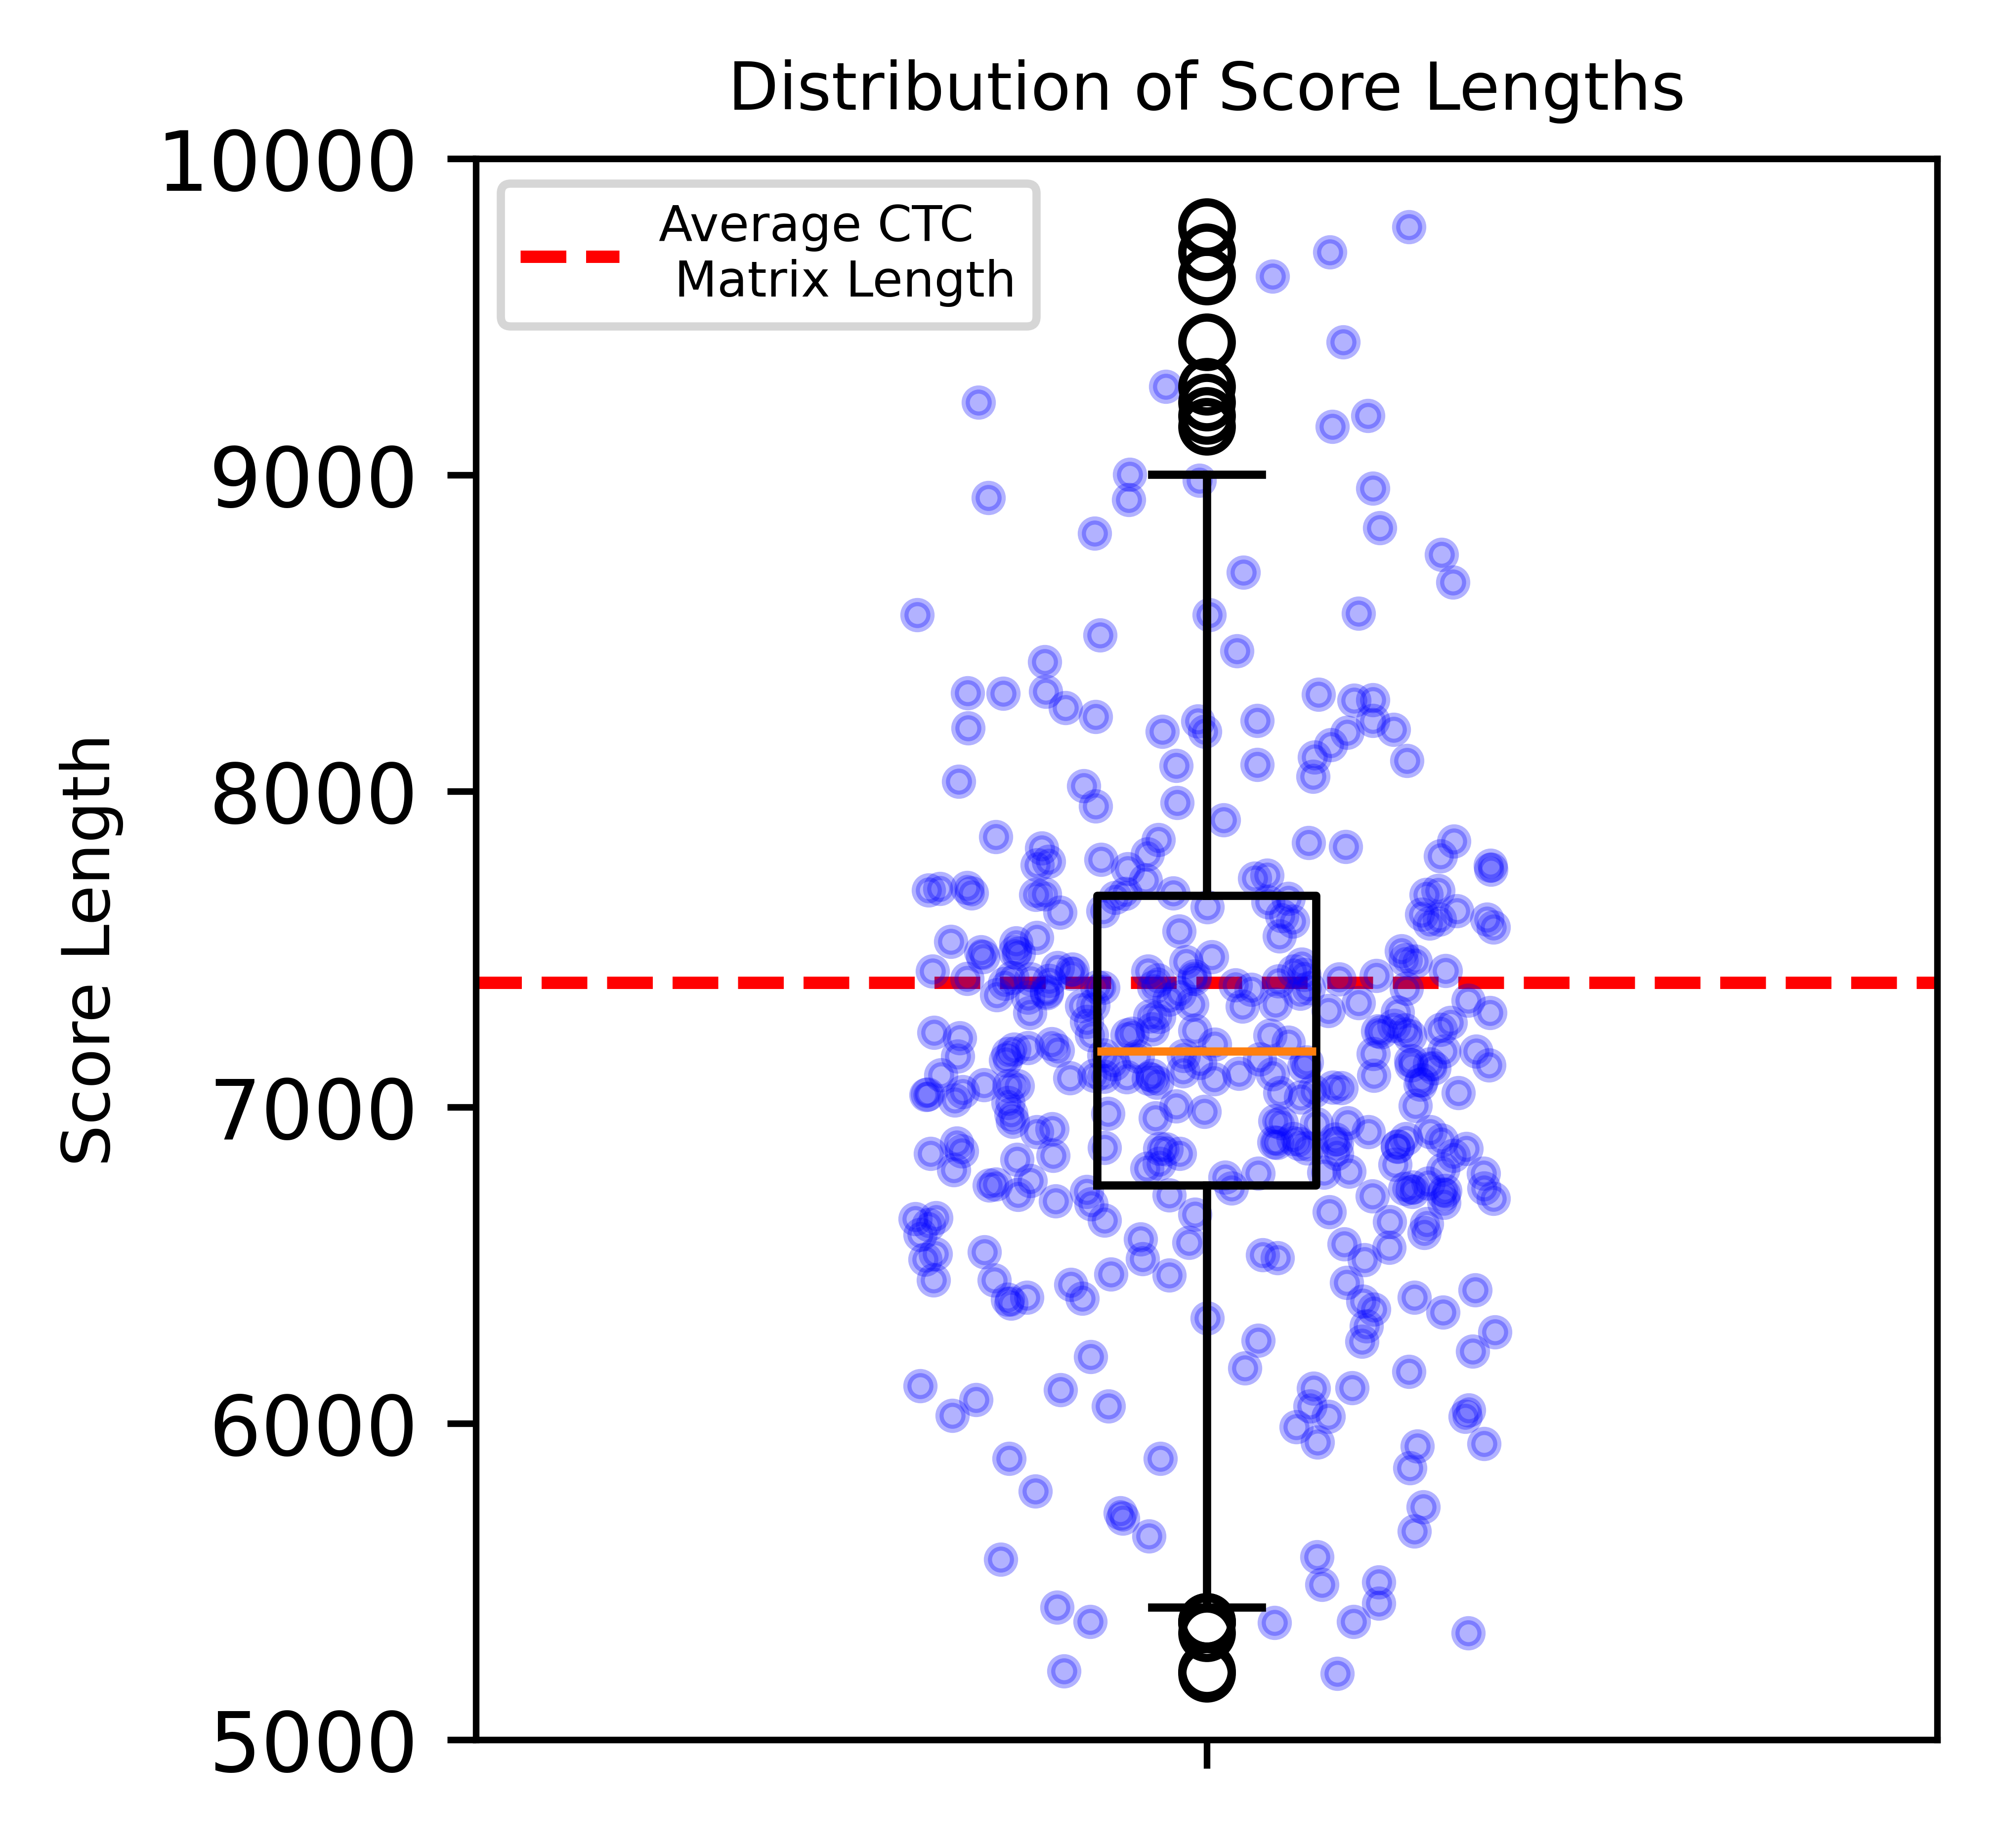

In [3]:
y1 = baseline_x
print(np.mean(y1))
print(np.std(y1))

fig,axes = plt.subplots(1,1,figsize=(3.25,3),layout="constrained",dpi=1200)
axes.boxplot(y1,labels=[""],zorder=100)
plt.scatter([1+np.random.uniform(-0.2,0.2,1) for _ in range(len(y1))], y1, alpha=0.3, color='b',s=10.0,zorder=10)
axes.tick_params(axis='x', labelsize=8)
axes.set_ylabel("Score Length",fontsize=8)
axes.set_ylim([5000,10000])
plt.title("Distribution of Score Lengths",fontsize=8)
plt.hlines(np.mean(y1),0.5,1.5,color="red",linestyle="dashed",label="Average CTC \n Matrix Length")
plt.legend(fontsize=6)
plt.savefig("score_length_distribution.png",format="png")
plt.show(fig)

## Batch Performance Comparisons

(2, 4, 8, 16, 32, 64, 100)
(1.7352669485087846, 2.953995814362662, 4.181955351514612, 5.206915775639532, 5.703429216836667, 5.688873901921139, 5.6392003297134625)
(2.3451440167427062, 1.3776088923215866, 0.9730976444482804, 0.7815472877025604, 0.7135094952583313, 0.7153350508213043, 0.7216361653804779)
1627.7803606987
1627.7803606987
Beam Speedups (77.4645571697741, 131.87018737239057, 186.68788666045782, 232.44344342917984, 254.60844454571094, 253.95867649396138, 251.74118409176054)
Beam Average Time 181.66554275631904


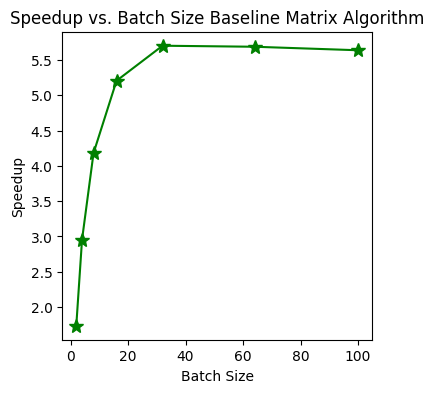

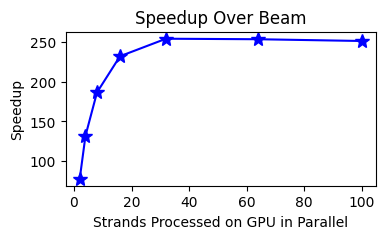

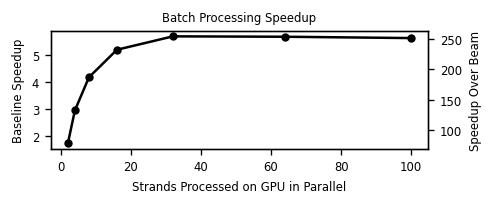

In [7]:
batch_sizes=[]
times=[]
batch_seconds_per_strand = []
#NOTE: I took the sum of the strand run times instead of the total script run time, there was some strange difference for beam. This should allow for a common baseline 
baseline = sum(strand_run_times["bonito_hedges_benchmark_window--0.err"][_] for _ in strand_run_times["bonito_hedges_benchmark_window--0.err"])
for b in batch_total_run_times:
    if "rna" in b: continue
    batch_sizes.append(int(b.split("--")[1].split(".err")[0]))
    times.append(baseline/batch_total_run_times[b])
    batch_seconds_per_strand.append(baseline/(400*times[-1]))    
batch_sizes,times,batch_seconds_per_strand = zip(*sorted(zip(batch_sizes,times,batch_seconds_per_strand),key=lambda x: x[0]))
plt.figure(figsize=(4, 4))
baseline_speedup=(batch_sizes,times)
plt.plot(batch_sizes,times,marker="*",ms=10,color="green")
print(batch_sizes)
print(times)
print(batch_seconds_per_strand)
print(baseline)
print(np.sum([strand_run_times["bonito_hedges_benchmark_window--0.err"][_] for _ in strand_run_times["bonito_hedges_benchmark_window--0.err"]]))

plt.title("Speedup vs. Batch Size Baseline Matrix Algorithm")
plt.xlabel("Batch Size")
plt.ylabel("Speedup")

batch_sizes=[]
times=[]
baseline = sum(strand_run_times["bonito_hedges_benchmark_beam.err"][_] for _ in strand_run_times["bonito_hedges_benchmark_beam.err"])
for b in batch_total_run_times:
    if "rna" in b: continue
    batch_sizes.append(int(b.split("--")[1].split(".err")[0]))
    times.append(baseline/batch_total_run_times[b])
batch_sizes,times = zip(*sorted(zip(batch_sizes,times),key=lambda x: x[0]))
plt.figure(figsize=(4, 2))
beam_speedup=(batch_sizes,times)
plt.plot(batch_sizes,times,marker="*",ms=10,color="blue")
plt.title("Speedup Over Beam")
plt.xlabel("Strands Processed on GPU in Parallel")
plt.ylabel("Speedup")

plt.figure(figsize=(4, 1.6),dpi=120,constrained_layout=True)
ax1=plt.gca()
ax2=ax1.twinx()
beam_speedup=(batch_sizes,times)
print("Beam Speedups {}".format(times))
print("Beam Average Time {}".format(baseline/400))
ax1.plot(*baseline_speedup,marker="o",ms=4,color="black")
ax2.plot(*beam_speedup,marker="*",color="w",markersize=0,linewidth=0)
plt.title("Batch Processing Speedup",fontsize=7)
ax1.set_xlabel("Strands Processed on GPU in Parallel",fontsize=7)
ax1.set_ylabel("Baseline Speedup",fontsize=7)
ax2.set_ylabel("Speedup Over Beam",fontsize=7)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax2.yaxis.set_tick_params(labelsize=7)
plt.savefig("batch_speedup.png",dpi=1200)


## Memory Analysis

This section is a estimate memory analysis between the Alignment Matrix algorithm and the Beam Algorithm. Estimates are based on our implementations of the algorithms and consider the main arrays and data structures need for the algorithm. The main idea here is to show how fast the Beam Algorithm's memory grows compared to our Alignment Algorithm as the length of a strand grows and shrinks. Estimates are constructed to be as accurate as possible, taking into account all intermediate values that are generated in the process of calculating each step of each algorithms' trellis.

x 1.0 -- beam meory 1.6616448 GB -- matrix memory 0.031472208 GB


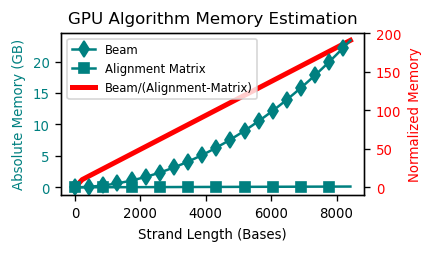

In [7]:
T = 7300 #Time-Length of CTC data input into the algorithm, this is variable so we assume the average as provided above in previous analysis
H = 256 #Number of states as determined by the number of history bits 
L = 6 #Length of String that needs to be calculated out for the alignment matrix each step
MESSAGE_LENGTH=87 #Length of the encoded message in bytes
WINDOW_FACTOR = 1 #Windowing used to reduce memory overhead
CANDIDATE_PATHS = 3 #Number of candidate paths that each state in the trellis must consider before updating
N_BASES = 4 #Number of bases 
E=2 #number of edges that are calculated per viterbi state
LIST_SIZE = 1  #Size of list for Beam algorithm, our implementations on really use 1 entry
MESSAGE_LENGTH_BASES=2160 #Length of the message in bases, after encoding, and only considers the payload portion of the strand that is processed


x = list(np.arange(0,4,0.1))
alignment_matrix_memory=[]
beam_memory=[]
for length_factor in x:
    message_length_after_factor = length_factor*MESSAGE_LENGTH_BASES
    T_after_factor = T*length_factor
    #Memory overheads for Alignment Matrix Algorithm
    scores = T_after_factor*5*4
    C = 2*(H*8+H*(4*7+12+4))
    F = H*T_after_factor*4*1*WINDOW_FACTOR
    alpha_t = H*T_after_factor*E*4*WINDOW_FACTOR
    BT_bases = H*message_length_after_factor*8
    BT_indexes = H*message_length_after_factor*8
    Targets = H*E*L*4
    mask=Targets
    out_scores = H*E*4
    
    alignment_matrix_GB = (scores+C+F+alpha_t+BT_bases+BT_indexes+Targets+mask+out_scores)/10**9
    alignment_matrix_memory.append(alignment_matrix_GB)
    #Memory overheads for Beam Algorithm
    TOTAL_PATH_BYTES=(12+4+7*4+(message_length_after_factor*2/8)+1+4*4)
    viterbi_matrix_memory = 2*TOTAL_PATH_BYTES*message_length_after_factor*LIST_SIZE*H
    total_candidate_memory = TOTAL_PATH_BYTES*H*CANDIDATE_PATHS*LIST_SIZE*message_length_after_factor
    
    beam_GB = (viterbi_matrix_memory+total_candidate_memory)/10**9
    beam_memory.append(beam_GB)
print("x {} -- beam meory {} GB -- matrix memory {} GB".format(x[10],beam_memory[10],alignment_matrix_memory[10]))

plt.figure(figsize=(3.5, 2),dpi=120,constrained_layout=True)
ax1=plt.gca()
x=np.array(x)*MESSAGE_LENGTH_BASES
ax2=ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax2.plot(x,np.array(beam_memory)/np.array(alignment_matrix_memory),marker="o",ms=0,color="red",markevery=2,zorder=1,linewidth=3,label="Beam/(Alignment-Matrix)")
ax1.plot(x,beam_memory,marker="d",ms=7,color="teal",markevery=2,label="Beam")
ax1.plot(x,alignment_matrix_memory,marker="s",ms=6,color="teal",markevery=4,label="Alignment Matrix")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2,l1+l2,fontsize=7)
ax2.tick_params(axis='y', labelcolor="red")
ax1.tick_params(axis='y', labelcolor="teal")
plt.xlabel("Strand Length (Bases)")
ax1.set_ylabel("Absolute Memory (GB)",color="teal",fontsize=8)
ax2.set_ylabel("Normalized Memory",color="red",fontsize=8)
ax1.set_xlabel("Strand Length (Bases)",fontsize=8)
plt.title("GPU Algorithm Memory Estimation",fontsize=10)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)
ax2.yaxis.set_tick_params(labelsize=8)
plt.savefig("memory_estimation.png",dpi=1200)


# RNA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


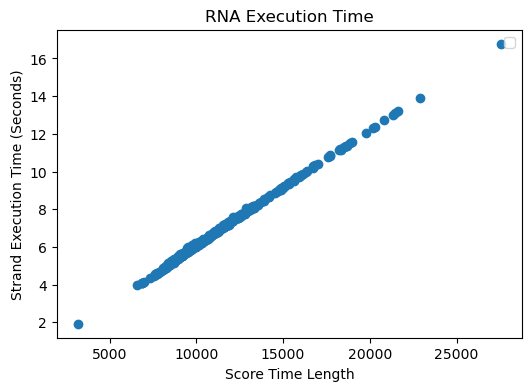

In [6]:
baseline_file = "rna_bonito_hedges_benchmark.err"
baseline_readIDs = [_ for _ in strand_run_times[baseline_file].keys() if _ not in first_readIDs]
baseline_y =np.array([strand_run_times[baseline_file][_] for _ in baseline_readIDs])
baseline_x =np.array([score_lengths[baseline_file][_] for _ in baseline_readIDs])
plt.figure(figsize=(6, 4))
baseline_x,baseline_y = zip(*sorted(zip(baseline_x,baseline_y),key=lambda x: x[0]))
plt.scatter(baseline_x,baseline_y)

plt.xlabel("Score Time Length")
plt.ylabel("Strand Execution Time (Seconds)")
plt.title("RNA Execution Time")
plt.legend()

11216.423558897242


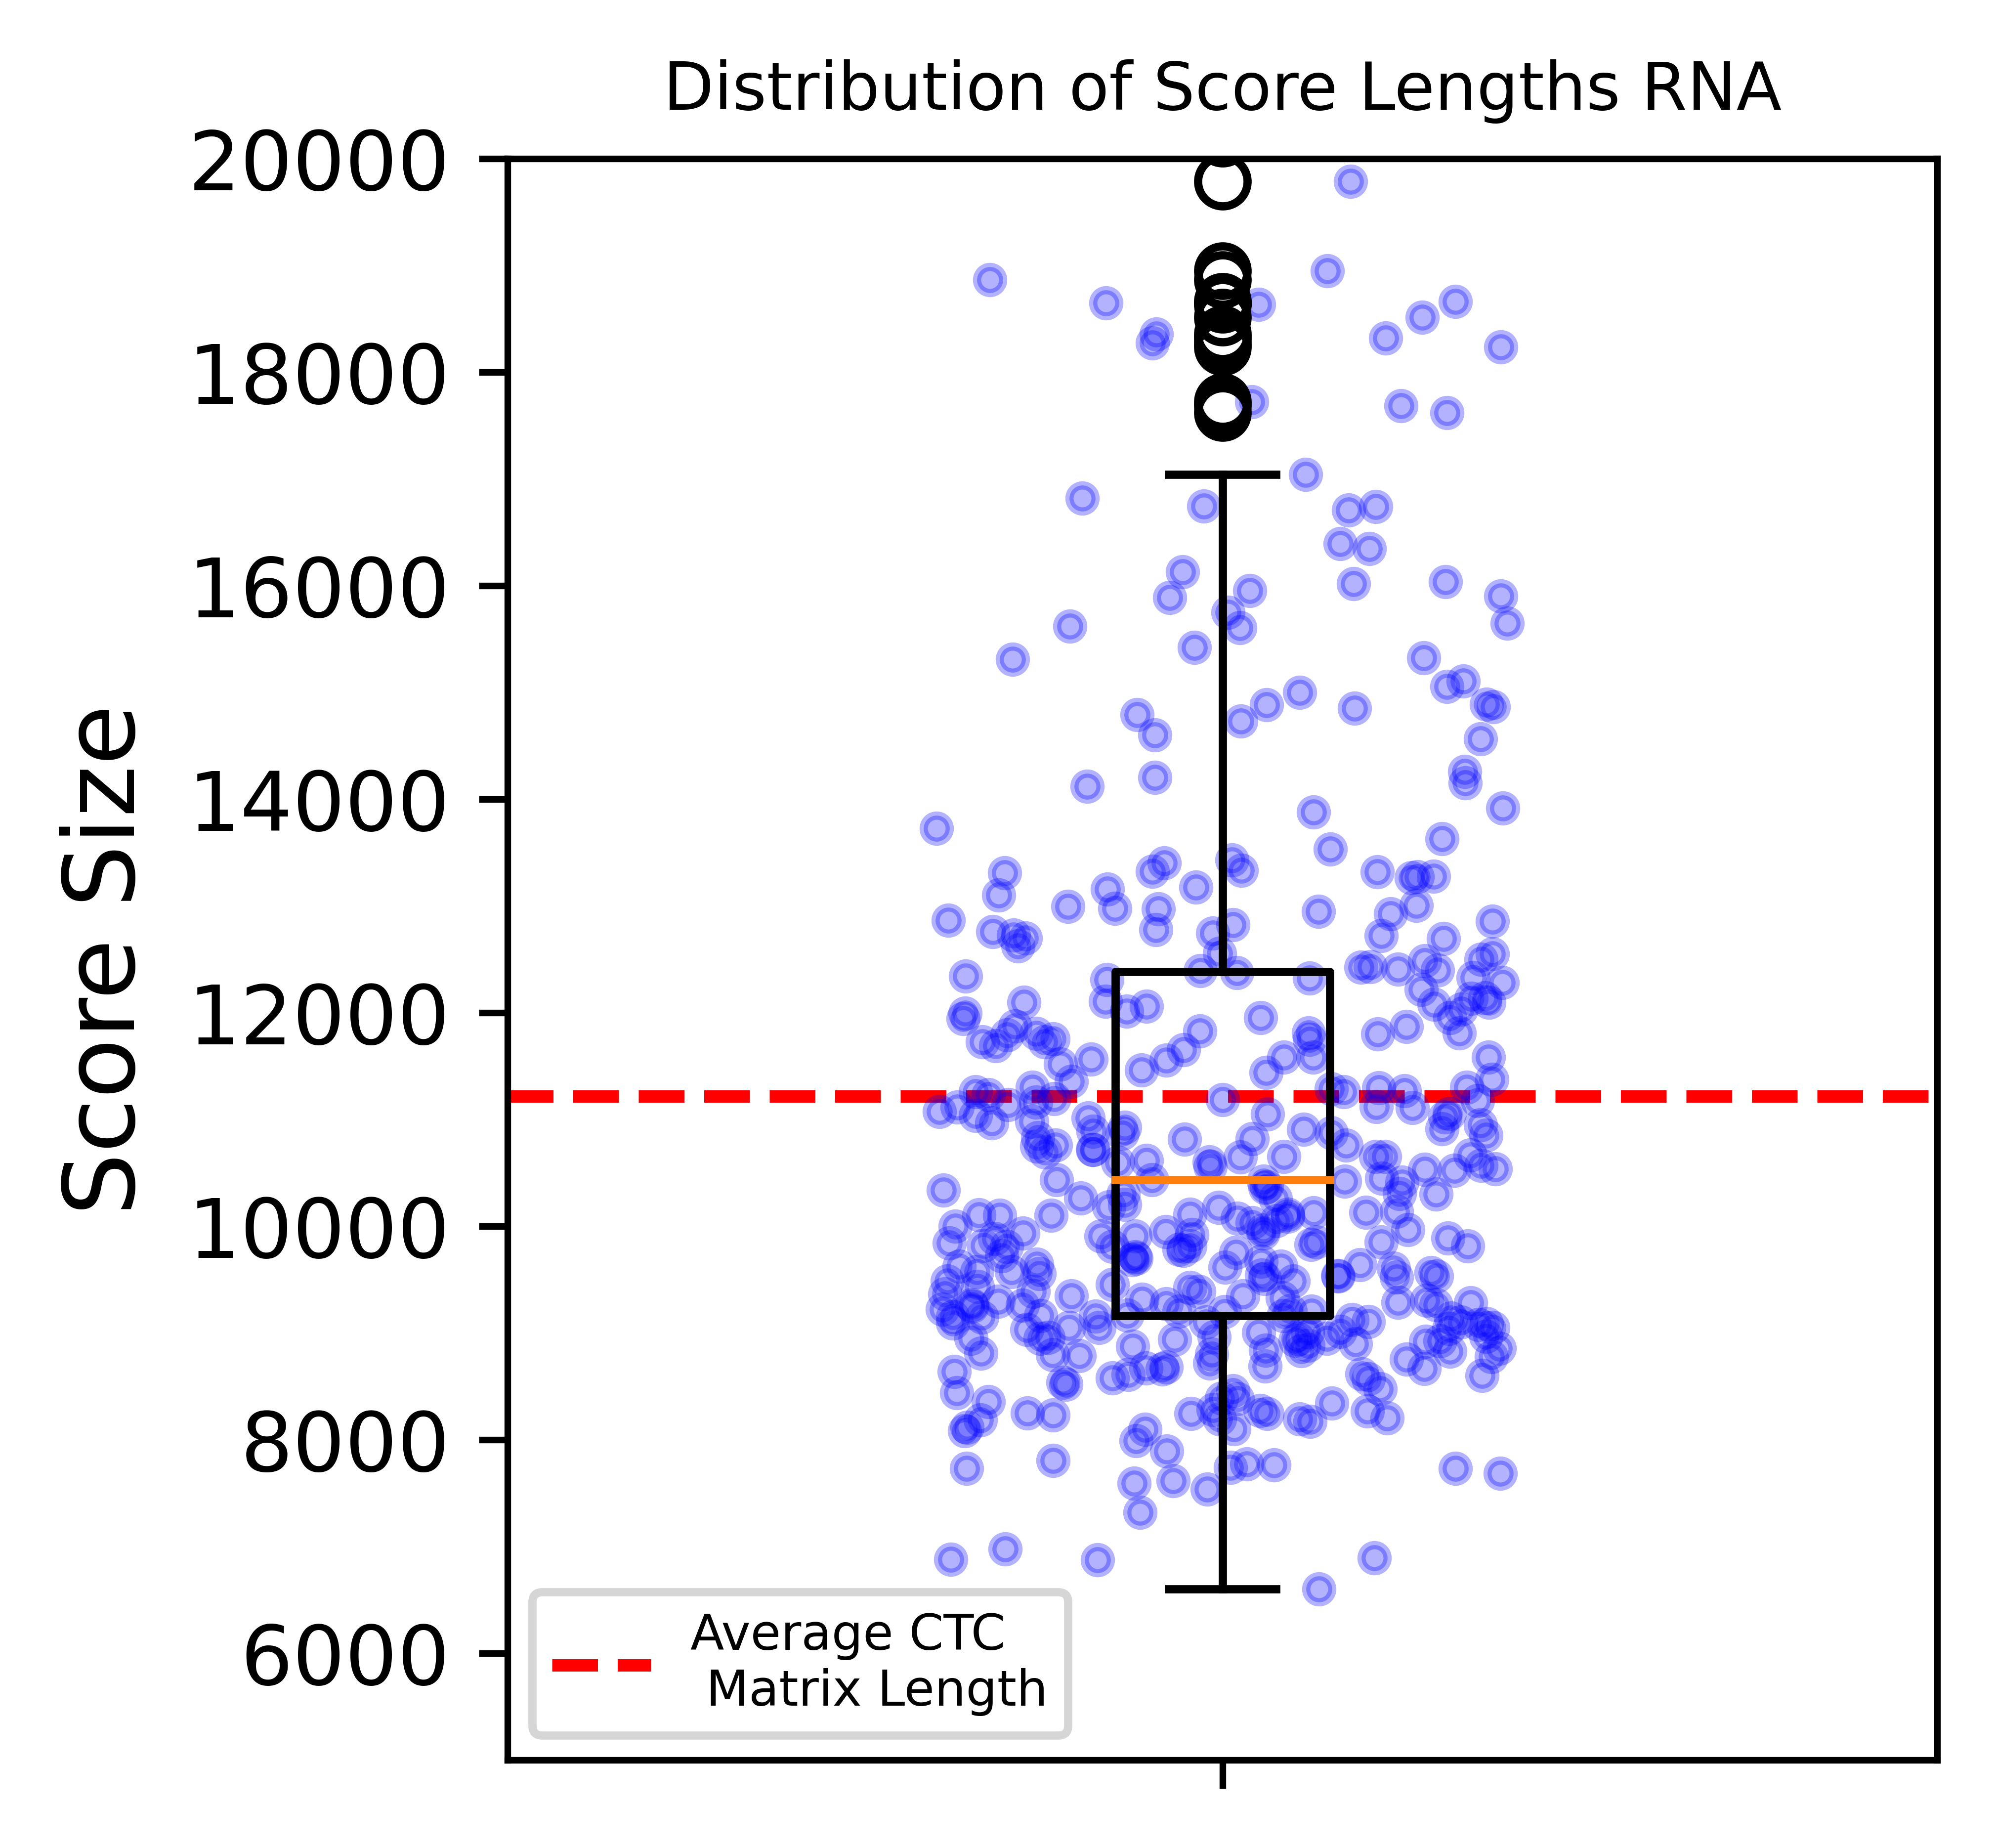

In [10]:


y1 = baseline_x
fig,axes = plt.subplots(1,1,figsize=(3.25,3),layout="constrained",dpi=1200)
axes.boxplot(y1,labels=[""],zorder=100)
plt.scatter([1+np.random.uniform(-0.2,0.2,1) for _ in range(len(y1))], y1, alpha=0.3, color='b',s=10.0,zorder=10)
axes.tick_params(axis='x', labelsize=8)
axes.set_ylabel("Score Size",fontsize=12)
axes.set_ylim([5000,20000])
plt.hlines(np.mean(y1),0.5,1.5,color="red",linestyle="dashed",label="Average CTC \n Matrix Length")
print(np.mean(y1))
plt.legend(fontsize=6)
plt.title("Distribution of Score Lengths RNA",fontsize=8)
plt.savefig("rna_score_length_distribution.png",format="png")



(2, 4, 8, 16, 32, 64)
(1.8178249339452506, 3.2175793858764874, 4.738129022281312, 5.6195467065299, 6.065445579797804, 6.422562969154397)
(3.7575660079369544, 2.122899347924626, 1.4416232964639957, 1.2155067902960528, 1.1261492812537304, 1.0635313679255742)


Text(0, 0.5, 'Speedup')

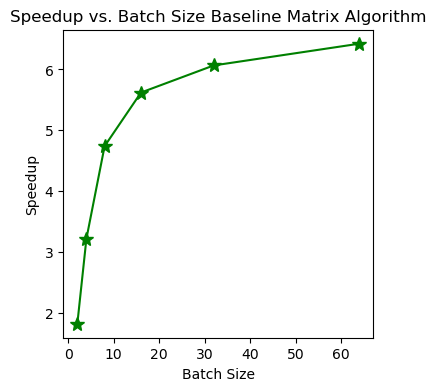

In [8]:

batch_sizes=[]
times=[]
batch_seconds_per_strand = []

baseline = sum([strand_run_times[baseline_file][_] for _ in strand_run_times[baseline_file]])
#baseline = total_run_times[baseline_file]

for b in batch_total_run_times:
    if "rna" not in b: continue
    batch_sizes.append(int(b.split("--")[1].split(".err")[0]))
    times.append(baseline/batch_total_run_times[b])
    batch_seconds_per_strand.append(np.mean(baseline_y)/times[-1])    
batch_sizes,times,batch_seconds_per_strand = zip(*sorted(zip(batch_sizes,times,batch_seconds_per_strand),key=lambda x: x[0]))
plt.figure(figsize=(4, 4))
baseline_speedup=(batch_sizes,times)
plt.plot(batch_sizes,times,marker="*",ms=10,color="green")
print(batch_sizes)
print(times)
print(batch_seconds_per_strand)
plt.title("Speedup vs. Batch Size Baseline Matrix Algorithm")
plt.xlabel("Batch Size")
plt.ylabel("Speedup")
